<a href="https://colab.research.google.com/github/akjieettt/dri-beautiful-sisterhood-of-books/blob/main/DRIBeautifulSisterhoodOfBooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and Importing Data

In [1]:
!git clone https://github.com/akjieettt/dri-beautiful-sisterhood-of-books
%cd dri-beautiful-sisterhood-of-books/

Cloning into 'dri-beautiful-sisterhood-of-books'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 243.00 KiB | 11.04 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/dri-beautiful-sisterhood-of-books


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import geopandas as gpd

# Load the wine quality datasets
df = pd.read_csv("BSBMasterDatabase.csv")

# Printing the number of wines in each dataset
print(f"Total Number of Entries: {len(df)}")
print(f"Total Number of NaNs:")
display(df.isna().sum())

print("\nThe Beautiful Sisterhood of Books Dataset:")
display(df.head())

Total Number of Entries: 1310
Total Number of NaNs:


,0
ID,0
author_name_variants,14
Author - Standardized (LOC listing when available),14
Contributing State,58
Title - Standardized,49
Publication Info,153
GENRE(s),77
KEYWORDS,369
Link to text,300
Research Notes,1063



The Beautiful Sisterhood of Books Dataset:


,ID,author_name_variants,Author - Standardized (LOC listing when available),Contributing State,Title - Standardized,Publication Info,GENRE(s),KEYWORDS,Link to text,Research Notes,Digital Source Notes
0,1,Marion Vaughn,"Stella (Scott) Gilman, (pseudonym Marion Vaughn)",Alabama,Mothers in Council,"New York: Harper & Brothers, 1884.","Textbook, Advice Literature","Child Rearing, Domestic Science, Conduct",https://books.google.com/books?id=4fkaAAAAYAAJ&,NaN,NaN
1,2,Mary W. Loughborough,Mary Ann (Webster) Loughborough,Arkansas,My Cave Life in Vicksburg.:[sic] With Letters ...,"New York: D. Appleton & Co., 1864.",Memoir,"Life Writing, War, Politics, Region & Regionalism",https://hdl.handle.net/2027/uc2.ark:/13960/t3v...,NaN,NaN
2,3,Mary H. Field,Mary H. (Bacon) Field,California,An Arboreal Song of the Alameda (The Beautiful...,"San Francisco: The Society, 1878.","Poetry, History","Region & Regionalism, Philosophy & Religion",https://hdl.handle.net/2027/loc.ark:/13960/t5p...,NaN,NaN
3,4,"Mary O. Stanton, M.O. Stanton",Mary Olmstead Stanton,California,Chart for the Delineations of Mental and Physi...,"Philadelphia: F.A. Davis, 1890.",Textbook,"Psychology, Science & Invention, Race",NaN,This is a pamphlet that preceded longer works ...,Still searching for digitized text.
4,5,Mrs. N. Furlong,Mrs. N. Furlong,California,"Cozenza: A Tale of Italy, and Other Poems","San Francisco: B.F. Sterrett, 1880.",Poetry,Nationalism,https://books.google.com/books?id=SwkPAAAAIAAJ&,NaN,NaN


## Visualizations

In [3]:
# Clean + count unique authors per state
df_bsb = df.copy()
df_bsb.columns = df_bsb.columns.astype(str).str.strip()

STATE_COL = "Contributing State"
AUTHOR_COL = "Author - Standardized (LOC listing when available)"

df_bsb[STATE_COL] = df_bsb[STATE_COL].astype(str).str.strip()
df_bsb[AUTHOR_COL] = df_bsb[AUTHOR_COL].astype(str).str.strip()

# Keep only valid rows
df_bsb = df_bsb[
    df_bsb[STATE_COL].notna() & (df_bsb[STATE_COL] != "") & (df_bsb[STATE_COL].str.lower() != "nan") &
    df_bsb[AUTHOR_COL].notna() & (df_bsb[AUTHOR_COL] != "") & (df_bsb[AUTHOR_COL].str.lower() != "nan")
].copy()

# Count unique authors per state
counts = (
    df_bsb.groupby(STATE_COL)[AUTHOR_COL]
    .nunique()
    .reset_index(name="author_count")
)

display(counts.sort_values("author_count", ascending=False).head(10))

,Contributing State,author_count
18,Massachusetts,151
27,New York,85
29,Pennsylvania,79
7,Foreign,42
22,Miscellaneous,40
30,Rhode Island,39
8,Illinois,33
4,Connecticut,27
25,New Hampshire,22
21,Minnesota,15


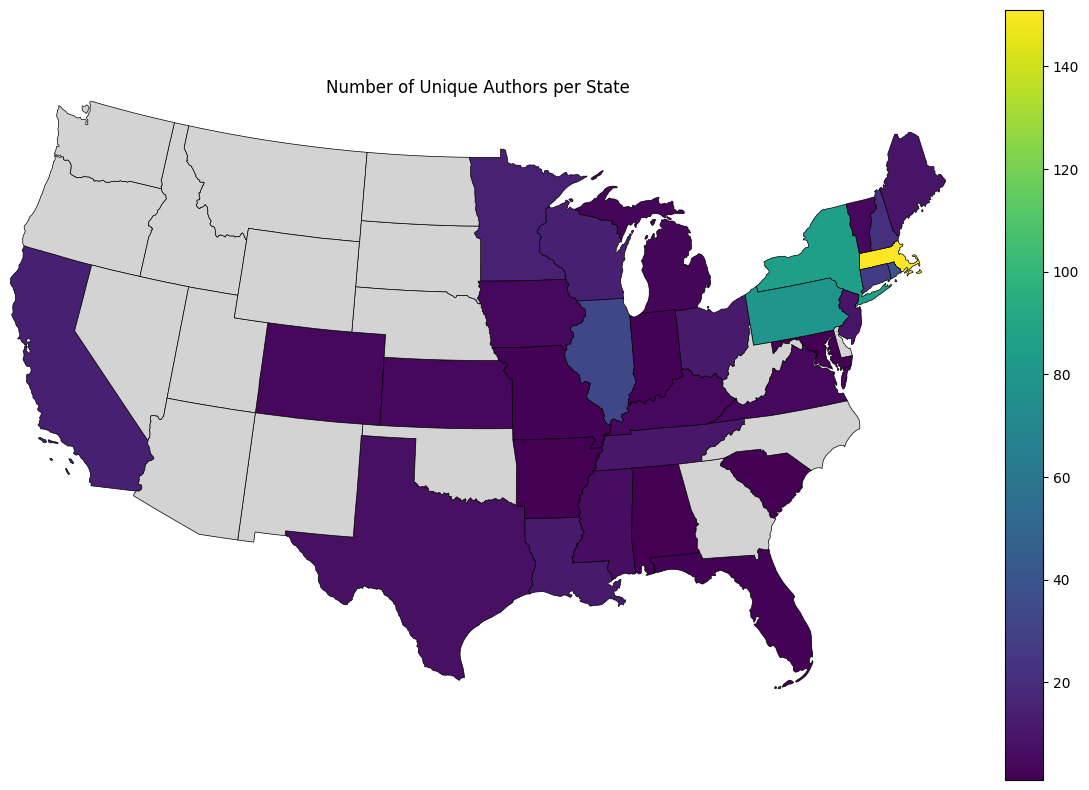

In [4]:
# Load states + merge counts
states_url = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip"
states = gpd.read_file(states_url)

# Drop territories
states = states[~states["STUSPS"].isin(["PR", "VI", "GU", "MP", "AS"])].copy()

# Merge by full state name
merged = states.merge(counts, left_on="NAME", right_on="Contributing State", how="left")

# Project + drop AK/HI for nicer scaling
merged = merged.to_crs("EPSG:5070")
map_df = merged[~merged["NAME"].isin(["Alaska", "Hawaii"])].copy()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

map_df.plot(
    column="author_count",
    ax=ax,
    legend=True,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.5,
    missing_kwds={"color": "lightgray", "label": "No data"},
)

# Zoom to bounds so the map fills the figure
xmin, ymin, xmax, ymax = map_df.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Number of Unique Authors per State")
ax.axis("off")
plt.tight_layout()
plt.show()

Text(0, 0.5, '')

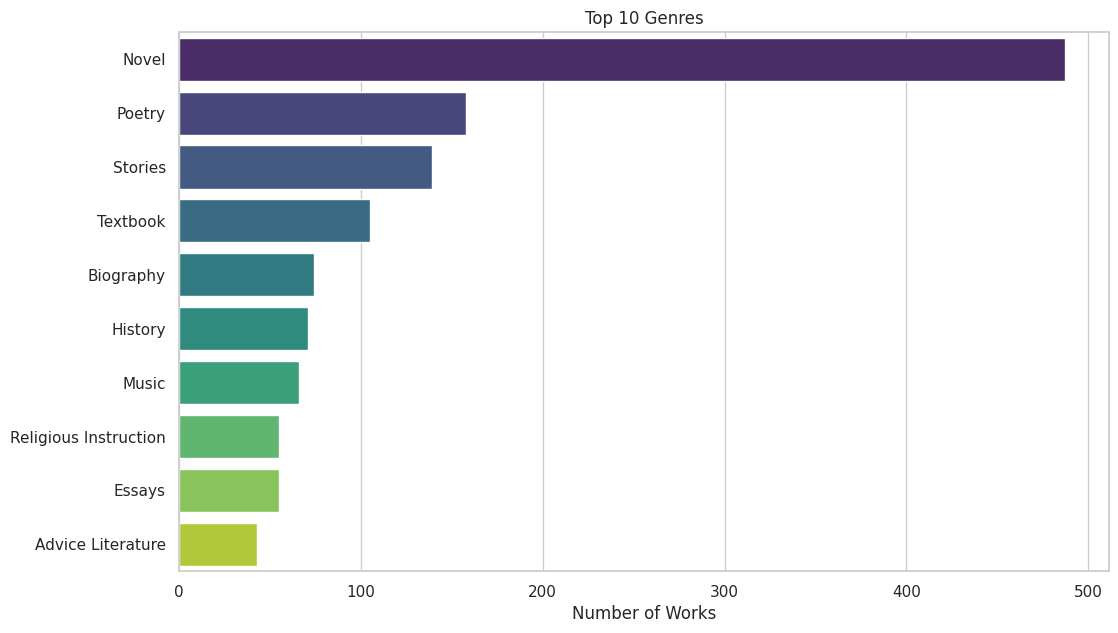

In [5]:
# Prepare data
genre_counts = (
    df["GENRE(s)"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
    .value_counts()
    .head(10)
)

plot_df = genre_counts.reset_index()
plot_df.columns = ["Genre", "Count"]

# Style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

palette = sns.color_palette("viridis", len(plot_df))

ax = sns.barplot(
    data=plot_df,
    x="Count",
    y="Genre",
    hue="Genre",
    palette=palette,
    legend=False          # remove legend (since hue duplicates y)
)

# Titles & labels
ax.set_title("Top 10 Genres")
ax.set_xlabel("Number of Works")
ax.set_ylabel("")